In [1]:
#import numpy as np
#import pandas as pd
import seaborn as sns
#from matplotlib import pyplot as plt
import plotly.graph_objects as go

import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd            #for reading & storing data, pre-processing
import matplotlib.pylab as plt #for visualization
#for making sure matplotlib plots are generated in Jupyter notebook itself
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [2]:
df = pd.read_csv('covid_19_data.csv')

In [3]:
df.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [4]:
df.describe()

,SNo,Confirmed,Deaths,Recovered
count,116805.000000,1.168050e+05,116805.000000,1.168050e+05
mean,58403.000000,1.908217e+04,777.745473,1.117002e+04
std,33718.843434,5.825465e+04,2859.184068,6.258701e+04
min,1.000000,0.000000e+00,0.000000,0.000000e+00
25%,29202.000000,2.450000e+02,3.000000,4.000000e+00
50%,58403.000000,2.148000e+03,42.000000,4.260000e+02
75%,87604.000000,1.037400e+04,331.000000,3.829000e+03
max,116805.000000,1.242770e+06,42072.000000,2.670256e+06


In [5]:
#df.drop(['SNo','Last Update'],axis=1)
#df.rename(columns={'ObservationDate':'Date','Province/State':'State','Country/Region':'Country'})

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116805 entries, 0 to 116804
Data columns (total 8 columns):
SNo                116805 non-null int64
ObservationDate    116805 non-null object
Province/State     81452 non-null object
Country/Region     116805 non-null object
Last Update        116805 non-null object
Confirmed          116805 non-null float64
Deaths             116805 non-null float64
Recovered          116805 non-null float64
dtypes: float64(3), int64(1), object(4)
memory usage: 7.1+ MB


In [7]:
df = df.drop(['SNo','Last Update'],axis=1)

In [8]:
df = df.rename(columns={'ObservationDate':'Date','Province/State':'State','Country/Region':'Country'})

In [9]:
df.head()

,Date,State,Country,Confirmed,Deaths,Recovered
0,01/22/2020,Anhui,Mainland China,1.0,0.0,0.0
1,01/22/2020,Beijing,Mainland China,14.0,0.0,0.0
2,01/22/2020,Chongqing,Mainland China,6.0,0.0,0.0
3,01/22/2020,Fujian,Mainland China,1.0,0.0,0.0
4,01/22/2020,Gansu,Mainland China,0.0,0.0,0.0


In [10]:
df.tail()

,Date,State,Country,Confirmed,Deaths,Recovered
116800,09/23/2020,Zaporizhia Oblast,Ukraine,3149.0,49.0,1158.0
116801,09/23/2020,Zeeland,Netherlands,1270.0,72.0,0.0
116802,09/23/2020,Zhejiang,Mainland China,1282.0,1.0,1272.0
116803,09/23/2020,Zhytomyr Oblast,Ukraine,5191.0,92.0,2853.0
116804,09/23/2020,Zuid-Holland,Netherlands,29513.0,1372.0,0.0


In [11]:
confirmed=df.loc[df['Date'] == '09/23/2020']
#confirmed.head()
confirmed = confirmed.groupby(['Country']).sum()[['Confirmed','Recovered','Deaths']].sort_values(by=['Confirmed'], ascending=False)
confirmed.head()

,Confirmed,Recovered,Deaths
Country,,,
US,6933548.0,2670256.0,201884.0
India,5646010.0,4587613.0,90020.0
Brazil,4591364.0,4046827.0,138105.0
Russia,1117487.0,920602.0,19720.0
Colombia,784268.0,662277.0,24746.0


In [12]:
df.Date = pd.to_datetime(df.Date.astype(str), dayfirst=False, errors='coerce')

In [13]:
cumulative_confirmed = df.groupby('Date').Confirmed.sum()
cumulative_confirmed = cumulative_confirmed.groupby(cumulative_confirmed.index.to_period('y')).cumsum().reset_index()
for i in range(245,0,-1):
    cumulative_confirmed['Confirmed'].iloc[i] = cumulative_confirmed['Confirmed'].iloc[i]-cumulative_confirmed['Confirmed'].iloc[i-1]
cumulative_confirmed.head(10)

C:\Users\sathi.LAPTOP-6VSGULQ7\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Date,Confirmed
0,2020-01-22,555.0
1,2020-01-23,653.0
2,2020-01-24,941.0
3,2020-01-25,1438.0
4,2020-01-26,2118.0
5,2020-01-27,2927.0
6,2020-01-28,5578.0
7,2020-01-29,6165.0
8,2020-01-30,8235.0
9,2020-01-31,9925.0


In [14]:
per_day_cases=cumulative_confirmed.copy()
for i in range(245,0,-1):
    per_day_cases['Confirmed'].iloc[i] = per_day_cases['Confirmed'].iloc[i]-per_day_cases['Confirmed'].iloc[i-1]
per_day_cases.head(10)

,Date,Confirmed
0,2020-01-22,555.0
1,2020-01-23,98.0
2,2020-01-24,288.0
3,2020-01-25,497.0
4,2020-01-26,680.0
5,2020-01-27,809.0
6,2020-01-28,2651.0
7,2020-01-29,587.0
8,2020-01-30,2070.0
9,2020-01-31,1690.0


In [15]:
indexedDataset = per_day_cases.set_index(['Date'])
indexedDataset.head(5)

,Confirmed
Date,
2020-01-22,555.0
2020-01-23,98.0
2020-01-24,288.0
2020-01-25,497.0
2020-01-26,680.0


C:\Users\sathi.LAPTOP-6VSGULQ7\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



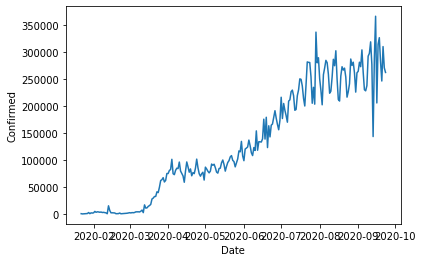

In [16]:
## plot graph
plt.xlabel('Date')
plt.ylabel('Confirmed')
plt.plot(indexedDataset)

In [17]:
#Determine rolling statistics
rolmean = indexedDataset.rolling(window=7).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
rolstd = indexedDataset.rolling(window=7).std()
print(rolmean,rolstd)

                Confirmed
Date                     
2020-01-22            NaN
2020-01-23            NaN
2020-01-24            NaN
2020-01-25            NaN
2020-01-26            NaN
...                   ...
2020-09-19  275587.714286
2020-09-20  290322.571429
2020-09-21  293565.142857
2020-09-22  279877.857143
2020-09-23  287968.571429

[246 rows x 1 columns]                Confirmed
Date                    
2020-01-22           NaN
2020-01-23           NaN
2020-01-24           NaN
2020-01-25           NaN
2020-01-26           NaN
...                  ...
2020-09-19  76379.900907
2020-09-20  53101.886812
2020-09-21  53633.044868
2020-09-22  42888.009558
2020-09-23  30083.906095

[246 rows x 1 columns]


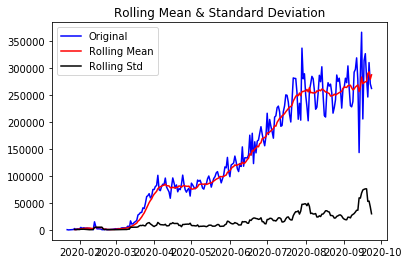

In [18]:
#Plot rolling statistics
orig = plt.plot(indexedDataset, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [19]:
#Perform Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(indexedDataset['Confirmed'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                   0.044269
p-value                          0.962044
#Lags Used                      13.000000
Number of Observations Used    232.000000
Critical Value (1%)             -3.458855
Critical Value (5%)             -2.874080
Critical Value (10%)            -2.573453
dtype: float64


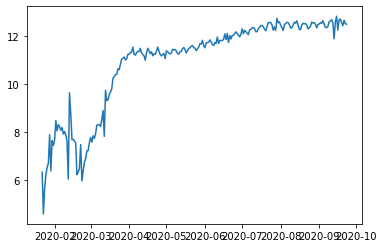

In [20]:
#Estimating trend
indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)

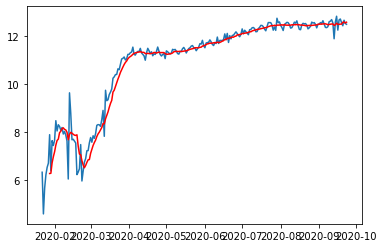

In [21]:
#The below transformation is required to make series stationary
movingAverage = indexedDataset_logScale.rolling(window=7).mean()
movingSTD = indexedDataset_logScale.rolling(window=7).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

In [22]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

,Confirmed
Date,
2020-01-28,1.614682
2020-01-29,0.099007
2020-01-30,0.923523
2020-01-31,0.467914
2020-02-01,0.484541
2020-02-02,1.016710
2020-02-03,0.396609
2020-02-04,0.597027
2020-02-05,0.263443


In [23]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=7).mean()
    movingSTD = timeseries.rolling(window=7).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Confirmed'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

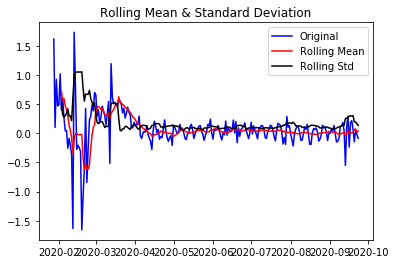

Results of Dickey Fuller Test:
Test Statistic                  -2.757440
p-value                          0.064615
#Lags Used                      15.000000
Number of Observations Used    224.000000
Critical Value (1%)             -3.459885
Critical Value (5%)             -2.874531
Critical Value (10%)            -2.573694
dtype: float64


In [24]:
test_stationarity(datasetLogScaleMinusMovingAverage)

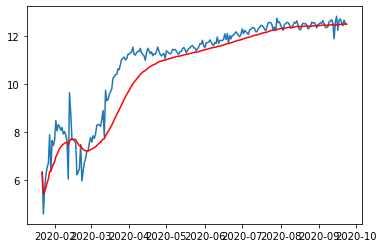

In [25]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

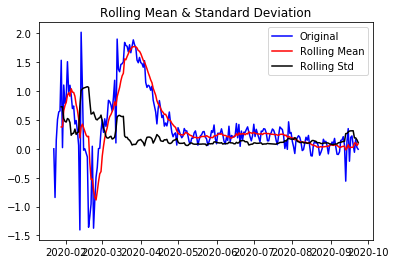

Results of Dickey Fuller Test:
Test Statistic                  -2.900516
p-value                          0.045288
#Lags Used                      14.000000
Number of Observations Used    231.000000
Critical Value (1%)             -3.458980
Critical Value (5%)             -2.874135
Critical Value (10%)            -2.573482
dtype: float64


In [26]:
datasetLogScaleMinusExponentialMovingAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusExponentialMovingAverage)

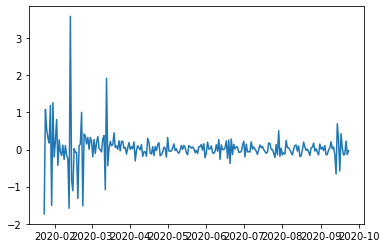

In [27]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

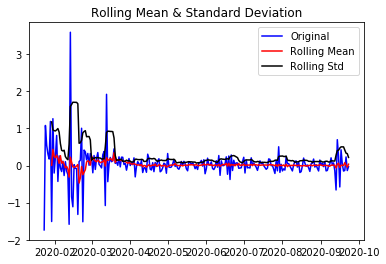

Results of Dickey Fuller Test:
Test Statistic                  -3.746572
p-value                          0.003504
#Lags Used                      13.000000
Number of Observations Used    231.000000
Critical Value (1%)             -3.458980
Critical Value (5%)             -2.874135
Critical Value (10%)            -2.573482
dtype: float64


In [28]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

C:\Users\sathi.LAPTOP-6VSGULQ7\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

C:\Users\sathi.LAPTOP-6VSGULQ7\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



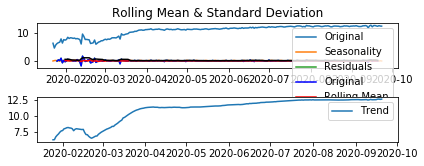

Results of Dickey Fuller Test:
Test Statistic                -5.740464e+00
p-value                        6.293014e-07
#Lags Used                     1.300000e+01
Number of Observations Used    2.260000e+02
Critical Value (1%)           -3.459620e+00
Critical Value (5%)           -2.874415e+00
Critical Value (10%)          -2.573632e+00
dtype: float64


In [29]:
decomposition = seasonal_decompose(indexedDataset_logScale) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logScale, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

#there can be cases where an observation simply consisted of trend & seasonality. In that case, there won't be 
#any residual component & that would be a null or NaN. Hence, we also remove such cases.
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

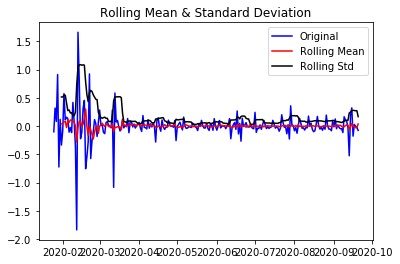

Results of Dickey Fuller Test:
Test Statistic                -5.740464e+00
p-value                        6.293014e-07
#Lags Used                     1.300000e+01
Number of Observations Used    2.260000e+02
Critical Value (1%)           -3.459620e+00
Critical Value (5%)           -2.874415e+00
Critical Value (10%)          -2.573632e+00
dtype: float64


In [30]:
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

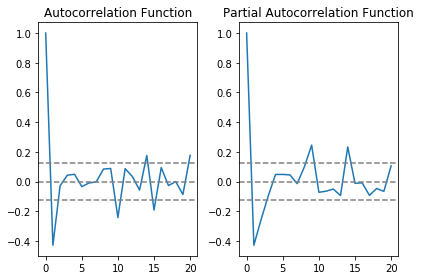

In [31]:
#ACF & PACF plots

lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()

In [32]:
lag_acf

array([ 1.00000000e+00, -4.28002488e-01, -2.75833373e-02,  4.31149657e-02,
        4.91579443e-02, -3.35490238e-02, -9.44540696e-03, -2.20931615e-03,
        8.44217589e-02,  8.82057400e-02, -2.41895433e-01,  8.70648569e-02,
        3.42189876e-02, -5.72272474e-02,  1.75807879e-01, -1.91402658e-01,
        9.42253431e-02, -2.65665683e-02,  9.95668126e-05, -8.66990859e-02,
        1.76588182e-01])

In [41]:
#AR Model
#making order=(2,1,0) gives RSS=1.5023
'''
model = ARIMA(indexedDataset_logScale, order=(1,1,0))
results_AR = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - datasetLogDiffShifting['Confirmed'])**2))
print('Plotting AR model')
'''

"\nmodel = ARIMA(indexedDataset_logScale, order=(1,1,0))\nresults_AR = model.fit(disp=-1)\nplt.plot(datasetLogDiffShifting)\nplt.plot(results_AR.fittedvalues, color='red')\nplt.title('RSS: %.4f'%sum((results_AR.fittedvalues - datasetLogDiffShifting['Confirmed'])**2))\nprint('Plotting AR model')\n"

In [42]:
#MA Model
'''
model = ARIMA(indexedDataset_logScale, order=(0,1,2))
results_MA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_MA.fittedvalues - datasetLogDiffShifting['Confirmed'])**2))
print('Plotting MA model')
'''

"\nmodel = ARIMA(indexedDataset_logScale, order=(0,1,2))\nresults_MA = model.fit(disp=-1)\nplt.plot(datasetLogDiffShifting)\nplt.plot(results_MA.fittedvalues, color='red')\nplt.title('RSS: %.4f'%sum((results_MA.fittedvalues - datasetLogDiffShifting['Confirmed'])**2))\nprint('Plotting MA model')\n"

In [43]:
# AR+I+MA = ARIMA model
'''
model = ARIMA(indexedDataset_logScale, order=(1,1,1))
results_ARIMA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - datasetLogDiffShifting['Confirmed'])**2))
print('Plotting ARIMA model')
'''

"\nmodel = ARIMA(indexedDataset_logScale, order=(1,1,1))\nresults_ARIMA = model.fit(disp=-1)\nplt.plot(datasetLogDiffShifting)\nplt.plot(results_ARIMA.fittedvalues, color='red')\nplt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - datasetLogDiffShifting['Confirmed'])**2))\nprint('Plotting ARIMA model')\n"